# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

## Modelo

In [1]:
import numpy as np
from numpy.linalg import det, inv

In [2]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [3]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)

    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

In [4]:
class QDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:,y.flatten()==idx], bias=True))
                      for idx in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

In [5]:
class TensorizedQDA(QDA):

    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self,x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))

## Código para pruebas

Seteamos los datos

In [6]:
# hiperparámetros
rng_seed = 6543

In [7]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True)

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [8]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [9]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [10]:
# preparing data, train - test validation
# 70-30 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4, random_state=rng_seed)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [11]:
qda = QDA()

qda.fit(train_x, train_y)

In [12]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

In [13]:
%%timeit

qda.predict(test_x)

1.52 ms ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit

model = QDA()
model.fit(train_x, train_y)
model.predict(test_x)

1.68 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Consigna



## Implementación
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para los puntos de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.
2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".
3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.

## Opcional

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4.Demostrar
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5.Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

# Resolución

### Implementación
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?

### 1.-

In [52]:
import matplotlib.pyplot as plt

In [53]:
a_priori = []
a_priori.append(None)
a_priori.append([1/3,1/3,1/3])
a_priori.append([0.9,0.05,0.05])
a_priori.append([0.05,0.9,0.05])
a_priori.append([0.05,0.05,0.9])

def comparar(X, y, a_priori, model):

    model_list = []    
    train_acc = []
    test_acc = []

    for idx, i in enumerate (a_priori):
        
        modeli = model()
        model_list.append(modeli)
        model_list[idx].fit(train_x, train_y, a_priori=i)
        train_acc.append(accuracy(train_y, model_list[idx].predict(train_x)))
        test_acc.append(accuracy(test_y, model_list[idx].predict(test_x)))
        
    return model_list, train_acc, test_acc
    

In [54]:
# Iris Dataset
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

model_list1, train_acc1, test_acc1 = comparar(train_x, train_y, a_priori, QDA)

In [55]:
for idx, i in enumerate (a_priori):
    print(f"QDA {idx} | a_priori = {i} | log(a_priori) = {model_list1[idx].log_a_priori}:")
    print(f"Dataset: Iris")
    print(f"Train (apparent) error is {1-train_acc1[idx]:.4f} while test error is {1-test_acc1[idx]:.4f}\n")

QDA 0 | a_priori = None | log(a_priori) = [-1.2039728  -1.13251384 -0.97344915]:
Dataset: Iris
Train (apparent) error is 0.0111 while test error is 0.0167

QDA 1 | a_priori = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333] | log(a_priori) = [-1.09861229 -1.09861229 -1.09861229]:
Dataset: Iris
Train (apparent) error is 0.0222 while test error is 0.0167

QDA 2 | a_priori = [0.9, 0.05, 0.05] | log(a_priori) = [-0.10536052 -2.99573227 -2.99573227]:
Dataset: Iris
Train (apparent) error is 0.0222 while test error is 0.0167

QDA 3 | a_priori = [0.05, 0.9, 0.05] | log(a_priori) = [-2.99573227 -0.10536052 -2.99573227]:
Dataset: Iris
Train (apparent) error is 0.0333 while test error is 0.0000

QDA 4 | a_priori = [0.05, 0.05, 0.9] | log(a_priori) = [-2.99573227 -2.99573227 -0.10536052]:
Dataset: Iris
Train (apparent) error is 0.0333 while test error is 0.0500



Se observan diferencias dependiendo de la probabilidad a priori utilizada.  \
En el gráfico de abajo se ve que las clases se distribuyen en partes iguales 1/3 cada una. \
En este caso es evidente que la elección de la probabilidad a priori va a influenciar la performance \
Al pasarle datos de train, la estimación la hace sobre datos de train la cual no está balanceada exáctamente \
como en los datos totales.

[]

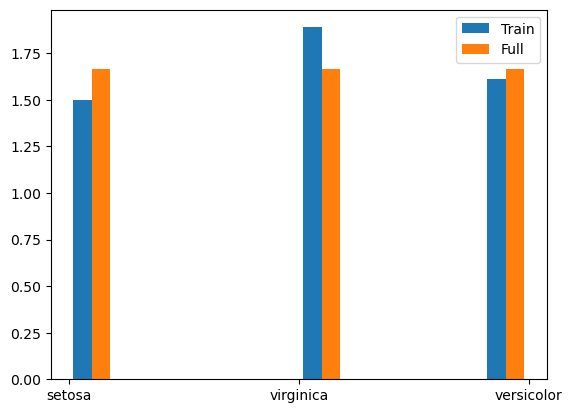

In [56]:
# plt.hist(y_full)
plt.hist([train_y.ravel(), y_full.ravel()], label=['Train', 'Full'], density=True)
plt.legend()
plt.plot()

### 2.-

In [57]:
# Penguins Dataset
X_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

model_list2, train_acc2, test_acc2 = comparar(train_x, train_y, a_priori, QDA)

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\pytorchgpu\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [58]:
for idx, i in enumerate (a_priori):
    print(f"QDA {idx} | a_priori = {i} | log(a_priori) = {model_list2[idx].log_a_priori}:")
    print(f"Dataset: Penguins")
    print(f"Train (apparent) error is {1-train_acc2[idx]:.4f} while test error is {1-test_acc2[idx]:.4f}\n")

QDA 0 | a_priori = None | log(a_priori) = [-0.89219318 -1.65944833 -0.91629073]:
Dataset: Penguins
Train (apparent) error is 0.0146 while test error is 0.0146

QDA 1 | a_priori = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333] | log(a_priori) = [-1.09861229 -1.09861229 -1.09861229]:
Dataset: Penguins
Train (apparent) error is 0.0098 while test error is 0.0073

QDA 2 | a_priori = [0.9, 0.05, 0.05] | log(a_priori) = [-0.10536052 -2.99573227 -2.99573227]:
Dataset: Penguins
Train (apparent) error is 0.0195 while test error is 0.0219

QDA 3 | a_priori = [0.05, 0.9, 0.05] | log(a_priori) = [-2.99573227 -0.10536052 -2.99573227]:
Dataset: Penguins
Train (apparent) error is 0.0098 while test error is 0.0219

QDA 4 | a_priori = [0.05, 0.05, 0.9] | log(a_priori) = [-2.99573227 -2.99573227 -0.10536052]:
Dataset: Penguins
Train (apparent) error is 0.0098 while test error is 0.0073



[]

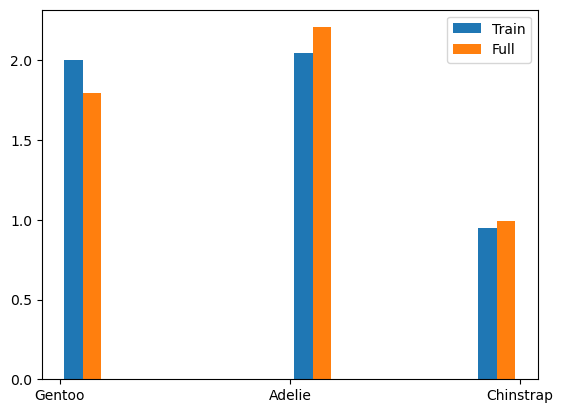

In [59]:
# plt.hist(y_full)
plt.hist([train_y.ravel(), y_full.ravel()], label=['Train', 'Full'], density=True)
plt.legend()
plt.plot()

### 3.-

In [60]:
class LDA(BaseBayesianClassifier):

  def _fit_params(self, X, y):
    # estimate global covariance matrix
    self.inv_cov = inv(np.cov(X, bias=True))

    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used    
    return self.means[class_idx].T @ self.inv_cov @ (x - 0.5*self.means[class_idx])

In [61]:
# Iris Dataset
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

model_list3, train_acc3, test_acc3 = comparar(train_x, train_y, a_priori, LDA)

In [62]:
for idx, i in enumerate (a_priori):
    print(f"LDA {idx} | a_priori = {i} | log(a_priori) = {model_list3[idx].log_a_priori}:")
    print(f"Dataset: Iris")
    print(f"Train (apparent) error is {1-train_acc3[idx]:.4f} while test error is {1-test_acc3[idx]:.4f}\n")
    

LDA 0 | a_priori = None | log(a_priori) = [-1.2039728  -1.13251384 -0.97344915]:
Dataset: Iris
Train (apparent) error is 0.1222 while test error is 0.2000

LDA 1 | a_priori = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333] | log(a_priori) = [-1.09861229 -1.09861229 -1.09861229]:
Dataset: Iris
Train (apparent) error is 0.1111 while test error is 0.1833

LDA 2 | a_priori = [0.9, 0.05, 0.05] | log(a_priori) = [-0.10536052 -2.99573227 -2.99573227]:
Dataset: Iris
Train (apparent) error is 0.5111 while test error is 0.5000

LDA 3 | a_priori = [0.05, 0.9, 0.05] | log(a_priori) = [-2.99573227 -0.10536052 -2.99573227]:
Dataset: Iris
Train (apparent) error is 0.5889 while test error is 0.6333

LDA 4 | a_priori = [0.05, 0.05, 0.9] | log(a_priori) = [-2.99573227 -2.99573227 -0.10536052]:
Dataset: Iris
Train (apparent) error is 0.5000 while test error is 0.6000



In [63]:
# Penguins Dataset
X_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

model_list4, train_acc4, test_acc4 = comparar(train_x, train_y, a_priori, LDA)

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\pytorchgpu\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [64]:
for idx, i in enumerate (a_priori):
    print(f"LDA {idx} | a_priori = {i} | log(a_priori) = {model_list4[idx].log_a_priori}:")
    print(f"Dataset: Penguins")
    print(f"Train (apparent) error is {1-train_acc4[idx]:.4f} while test error is {1-test_acc4[idx]:.4f}\n")

LDA 0 | a_priori = None | log(a_priori) = [-0.89219318 -1.65944833 -0.91629073]:
Dataset: Penguins
Train (apparent) error is 0.0195 while test error is 0.0219

LDA 1 | a_priori = [0.3333333333333333, 0.3333333333333333, 0.3333333333333333] | log(a_priori) = [-1.09861229 -1.09861229 -1.09861229]:
Dataset: Penguins
Train (apparent) error is 0.0098 while test error is 0.0073

LDA 2 | a_priori = [0.9, 0.05, 0.05] | log(a_priori) = [-0.10536052 -2.99573227 -2.99573227]:
Dataset: Penguins
Train (apparent) error is 0.4683 while test error is 0.3577

LDA 3 | a_priori = [0.05, 0.9, 0.05] | log(a_priori) = [-2.99573227 -0.10536052 -2.99573227]:
Dataset: Penguins
Train (apparent) error is 0.3805 while test error is 0.4161

LDA 4 | a_priori = [0.05, 0.05, 0.9] | log(a_priori) = [-2.99573227 -2.99573227 -0.10536052]:
Dataset: Penguins
Train (apparent) error is 0.4098 while test error is 0.4745



Se observa que el QDA es superior al LDA, lo cual tiene sentido ya que asumir que las covarianzas son iguales para cada clase es una asumsion muy grande.

## 4.-

In [85]:
## Seed1
rng_seed2 = 1568

# Iris Dataset
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed2)

model_list5, train_acc5, test_acc5 = comparar(train_x, train_y, a_priori, LDA)

# Penguins Dataset
X_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed2)

model_list6, train_acc6, test_acc6 = comparar(train_x, train_y, a_priori, LDA)

## Seed2
rng_seed3 = 234

# Iris Dataset
X_full, y_full = get_iris_dataset()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed3)

model_list7, train_acc7, test_acc7 = comparar(train_x, train_y, a_priori, LDA)

# Penguins Dataset
X_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed3)

model_list8, train_acc8, test_acc8 = comparar(train_x, train_y, a_priori, LDA)

d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\pytorchgpu\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
d:\Users\juanp_schamun\AppData\Local\anaconda3\envs\pytorchgpu\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [89]:
d = [['QDA', 'Iris',     rng_seed,  train_acc1, test_acc1],
     ['QDA', 'Penguins', rng_seed,  train_acc2, test_acc2],
     ['LDA', 'Iris',     rng_seed,  train_acc3, test_acc3],
     ['LDA', 'Penguins', rng_seed,  train_acc4, test_acc4],
     ['QDA', 'Iris',     rng_seed2, train_acc5, test_acc5],
     ['QDA', 'Penguins', rng_seed2, train_acc6, test_acc6],
     ['LDA', 'Iris',     rng_seed3, train_acc7, test_acc7],
     ['LDA', 'Penguins', rng_seed3, train_acc8, test_acc8],
    ]
    
headers = 'Modelo', 'Dataset', 'Seed', 'Error (train)', 'Error (test)'

print("{:<8} {:<10} {:<10} {:<15} {:<15}".format('Modelo', 'Dataset', 'Seed', 'Error (train)', 'Error (test)'))

for v in d:
    Modelo, Dataset, Seed, accu_train, accu_test = v
    for idx, i in enumerate (a_priori):
        print("{:<8} {:<10} {:<10} {:<15} {:<10}".format(Modelo, Dataset, Seed, f'{1-accu_train[idx]:.4f}', f'{1-accu_test[idx]:.4f}'))


Modelo   Dataset    Seed       Error (train)   Error (test)   
QDA      Iris       6543       0.0111          0.0167    
QDA      Iris       6543       0.0222          0.0167    
QDA      Iris       6543       0.0222          0.0167    
QDA      Iris       6543       0.0333          0.0000    
QDA      Iris       6543       0.0333          0.0500    
QDA      Penguins   6543       0.0146          0.0146    
QDA      Penguins   6543       0.0098          0.0073    
QDA      Penguins   6543       0.0195          0.0219    
QDA      Penguins   6543       0.0098          0.0219    
QDA      Penguins   6543       0.0098          0.0073    
LDA      Iris       6543       0.1222          0.2000    
LDA      Iris       6543       0.1111          0.1833    
LDA      Iris       6543       0.5111          0.5000    
LDA      Iris       6543       0.5889          0.6333    
LDA      Iris       6543       0.5000          0.6000    
LDA      Penguins   6543       0.0195          0.0219    
LDA      